In [ ]:
!pip install tensorflow==2.8
!pip install keras==2.8

### Load

In [2]:
import os
import numpy as np
from music21 import converter, pitch, interval, instrument, note, stream
from matplotlib import pyplot as plt

from xen.visualise import plotPart, plotSparseNoteSequence
from xen.data.songdata import SongDataSet

data_dir = "../../../ml_data/music/mutopia_guitar/"

dataset = SongDataSet()
dataset.loadMidiDir(data_dir)

print(f'Loaded {len(dataset.songs)} Songs') 


Loading 385 files
Loaded 385 Songs


### Filter

In [3]:
dataset.filterTimeSig('4/4')


print(f'{len(dataset.songs)} Songs') 

95 Songs


In [5]:
from xen.data.codecs import SparseNoteSequenceCodec, FlatNoteSequenceCodec

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
measuresPerSequence = 1

codec = FlatNoteSequenceCodec(ticksPerQuarter, measuresPerSequence, '4/4')
codec.initEncode(dataset)

print(dataset.sequences.shape)

Ignored 20 sequences from ../../../ml_data/music/mutopia_guitar/Matiegka3.mid
Ignored 2 sequences from ../../../ml_data/music/mutopia_guitar/capricho-arabe.mid
Ignored 24 sequences from ../../../ml_data/music/mutopia_guitar/carcassi-op60-03.mid
Ignored 3 sequences from ../../../ml_data/music/mutopia_guitar/horetzky29.mid
Ignored 84 sequences from ../../../ml_data/music/mutopia_guitar/sorf-op6n11.mid
Ignored 42 sequences from ../../../ml_data/music/mutopia_guitar/sorf-op6n07.mid
Ignored 69 sequences from ../../../ml_data/music/mutopia_guitar/claro-de-luna.mid
Ignored 70 sequences from ../../../ml_data/music/mutopia_guitar/moonlight-guitar-duo.mid
Ignored 1 sequences from ../../../ml_data/music/mutopia_guitar/bwv-1006a_3g.mid
Ignored 1 sequences from ../../../ml_data/music/mutopia_guitar/guitar-skole-no-09.mid
Ignored 2 sequences from ../../../ml_data/music/mutopia_guitar/Sor_Etude_Opus35_14.mid
Ignored 1 sequences from ../../../ml_data/music/mutopia_guitar/guitar-skole-no-05.mid
Ignored

In [45]:
import tensorflow as tf

inputShape = (dataset.sequences.shape[1])
latentShape = (30)

# encoder model
encoderInput = tf.keras.layers.Input(shape = inputShape)
encoderOutput = tf.keras.layers.Dense(latentShape, activation = 'tanh')(encoderInput)
encoder = tf.keras.Model(encoderInput, encoderOutput)

# decoder model
decoderInput = tf.keras.layers.Input(shape = latentShape)
decoderOutput = tf.keras.layers.Dense(inputShape, activation = 'sigmoid')(decoderInput)
decoder = tf.keras.Model(decoderInput, decoderOutput)

# autoencoder model
autoencoder = tf.keras.Model(encoderInput, decoder(encoderOutput))

In [46]:

autoencoder.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

autoencoder.fit(dataset.sequences, dataset.sequences, epochs = 1000)


Epoch 1/1000
99/99 [==============================] - 1s 2ms/step - loss: 0.1305
Epoch 2/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 3/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 4/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 5/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.0571
Epoch 6/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 7/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0529
Epoch 8/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0514
Epoch 9/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.0502
Epoch 10/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.0489
Epoch 11/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 12/1000
99/99 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 13/1000
99/99 [====

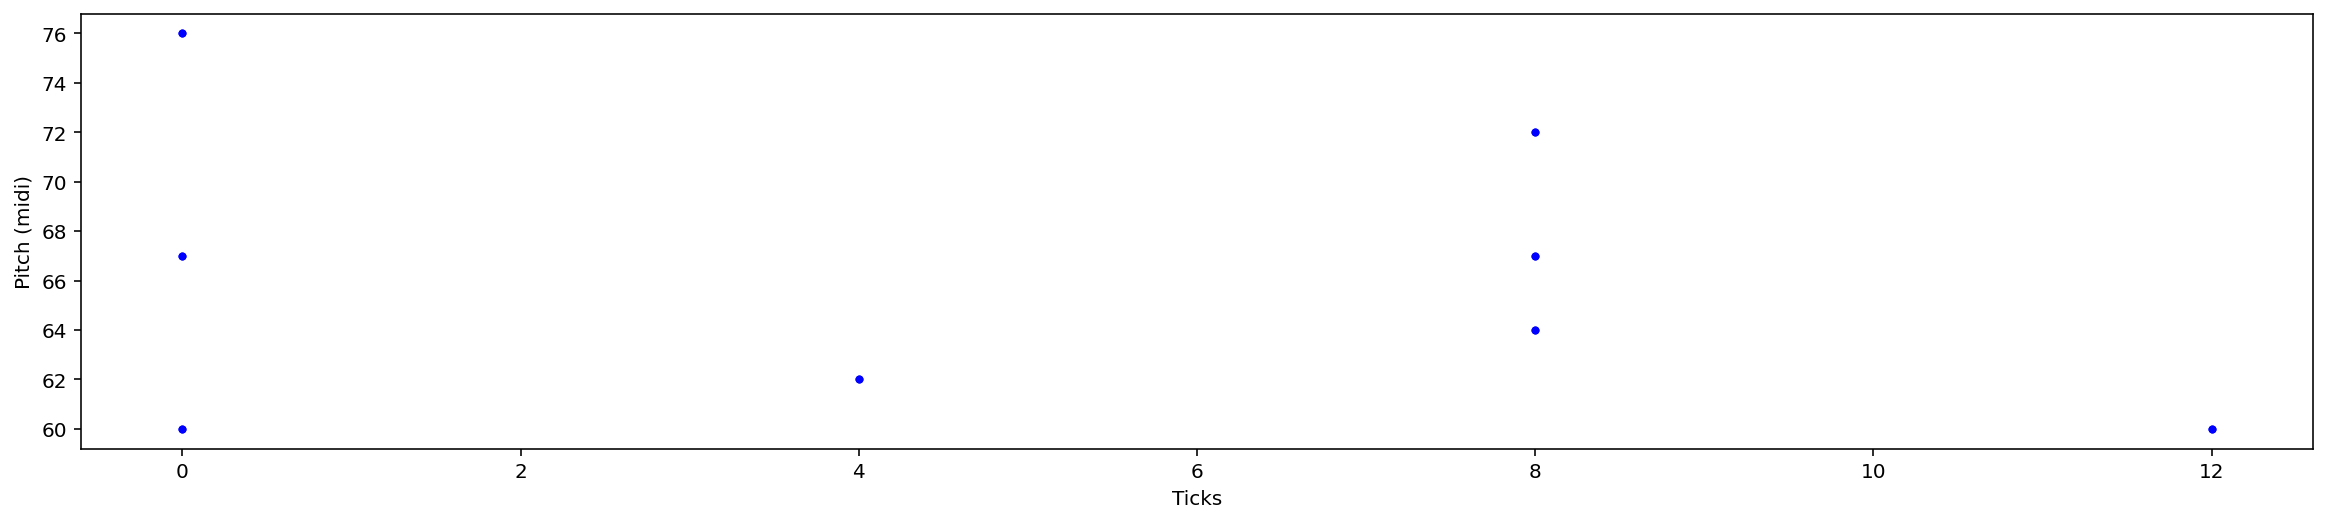

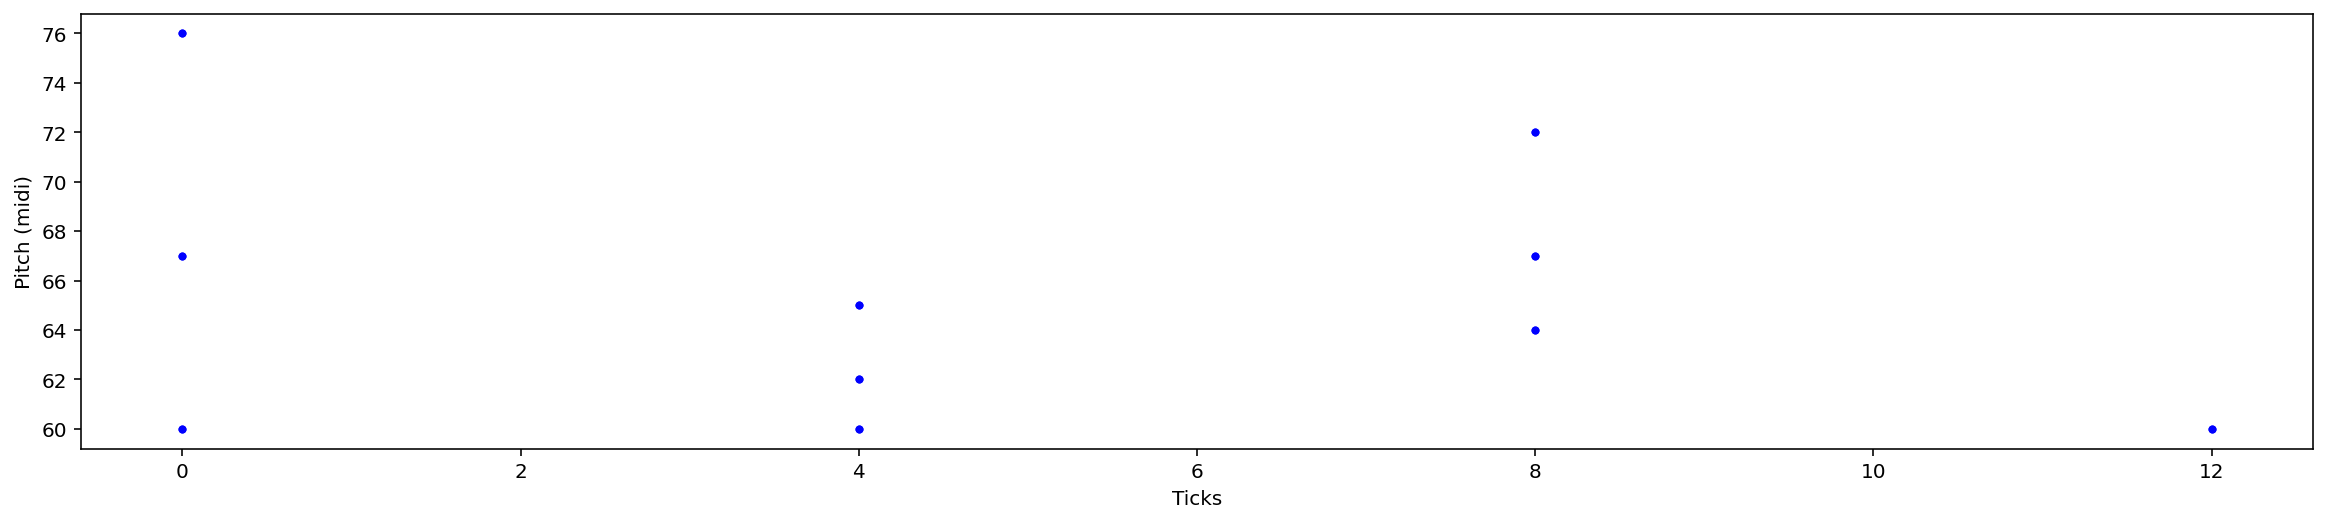

[0.99995613]


In [65]:


input = np.array([dataset.sequences[8]])

output = autoencoder.predict(input)

plotSparseNoteSequence(codec.decode(input[0:1])[0])
plotSparseNoteSequence(codec.decode(output[0:1])[0], threshold = 0.5)

# plotSparseNoteSequence(codec.decode(dataset.sequences[0]))
# plotSparseNoteSequence(codec.decode(output[0]))

print(np.amax(output, axis = 1))
